# SCRAPING

In [11]:
#SCRIPT PER LO SCRAPING DI TUTTI I DATI RELATIVI A SHOES DI lumberjack (SIA UOMO CHE DONNA)

import requests
from bs4 import BeautifulSoup
import pandas as pd

base_url = "https://www.lumberjack.com/it/shoes?page={}"

#Nel caso in cui si volesse fare un filtro solo donna da sito, la pagina da considerare è la seguente:
# base_url = "https://www.lumberjack.com/it/campaign/woman?category=shoes&page={}"

def get_shoe_links():
    shoe_links = []

    for page in range(1, 31):
        page_url = base_url.format(page)
        response = requests.get(page_url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Trovo tutti i link alle pagine delle scarpe nella pagina corrente
        for shoe_div in soup.find_all("div", class_="js-product-vertical col-6 col-lg-4 listing__col-product"):
            link = shoe_div.find("a", href=True)
            if link:
                shoe_links.append(link["href"])

    return shoe_links

def get_product_details(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    product_details = {}

    # Trova tutti i valori delle classi col-6 - dati scelti per lo studio
    for div in soup.find_all("div", class_="col-6"):
        text = div.get_text(strip=True)
        if "Marchio" in text:
            product_details["Marchio"] = text.replace("Marchio: ", "")
        elif "Modello" in text:
            product_details["Modello"] = text.replace("Modello: ", "")
        elif "Colore" in text:
            product_details["Colore"] = text.replace("Colore: ", "")
        elif "Materiale" in text:
            product_details["Materiale"] = text.replace("Materiale: ", "")
        elif "Altri Prodotti" in text:
            product_details["Altri Prodotti"] = text.replace("Altri Prodotti: ", "")
        elif "Genere" in text:
            product_details["Genere"] = text.replace("Genere: ", "")

    # Trova il prezzo del prodotto - presente nella stessa pagina ma con diverso riferimento
    price_div = soup.find("span", class_="product__prices-sale")
    if price_div:
        product_details["Prezzo"] = price_div.get_text(strip=True)

    return product_details

#Determino i link calolati tramite la prima funzione
shoe_links = get_shoe_links()
#Dichiaro un raccoglitore vuoto per la generazione dei dati dal ciclo for successivo
all_product_details = []

# Ciclo for per ricercare ricercare nelle singole pagine con i dati della prima funzione, e con la seconda estrarre i valori richiesti
for link in shoe_links:
    full_url = "https://www.lumberjack.com" + link
    product_details = get_product_details(full_url)
    all_product_details.append(product_details)

# Stampo il numero di pagine/scarpe trovare così da comparare al valore riportato sul sito
print(f"Numero totale di link trovati: {len(shoe_links)}")

# Creo un dataframe per l'elaborazione dei dati
df = pd.DataFrame(all_product_details)
print(df)

# Creo una copia del dataframe (da eventualmente utilizzare in script successivi)
df_copy = df.copy()

# Salvo il DataFrame in un file CSV (per avere una copia pronta per attività successive)
df_copy_lumberjack.to_csv("shoe_data_lumberjack.csv", index=False)

print("DataFrame Lumberjack salvato in 'shoe_data_lumberjack.csv'")

ConnectionError: HTTPSConnectionPool(host='www.lumberjack.com', port=443): Max retries exceeded with url: /it/shoes?page=1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002C400DE3AD0>: Failed to resolve 'www.lumberjack.com' ([Errno 11001] getaddrinfo failed)"))

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL della sitemap
sitemap_url = "https://www.kammi.it/sitemap.xml"

# Inizialmente si era considerato di utilizzare le pagine derivanti dalla scelta da sito:
    #pagina per le scarpe estive:
    # url = "https://www.kammi.it/scarpe-donna/" -> genero copy2

#Nel caso in cui si volessero considerare quelle invernali separatamente:
    # url = "https://www.kammi.it/scarpe-donna-autunno-inverno/" -> genero copy3

#Nel caso in cui volessimo entrambi i dataframe invernale ed estivo, potremmo far elaborare lo script di entrambi separatamente e poi unirli come sotto:
# df_kimmi = pd.concat([df_copy2, df_copy3], ignore_index=True)
# df_kimmi


# Richiedo accesso al sito per la richiesta di dati
response = requests.get(sitemap_url)
soup = BeautifulSoup(response.content, 'xml')

# Dopo verifica è emerso che non conviene estrarre tutti i link ma solo quelli con alla fine ".html"
urls = [loc.text for loc in soup.find_all('loc') if loc.text.endswith('.html')]

# Ho già i link, ma occorre una funzione per rintracciare i "pulsanti" contenenti le taglie
def extract_values(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Trovo tutti i pulsanti con la classe specifica che contiene i valori "value"
    buttons = soup.find_all('button', class_='content d-flex align-items-center justify-content-center p-2 checkRitiroPP')

    # Esporto tutte le taglie in un'unica stringa separati da "-" poichè mi interessa fare un check sul range di taglie
    valori = "-".join([button.get_text(strip=True) for button in buttons])

    return valori


# Funzione per estrarre i dati da una pagina, nel caso in cui siano assenti, considero giò un "Non disponibile" come valore di riferimento
def extract_data(url):
    page = requests.get(url)
    page_soup = BeautifulSoup(page.content, 'html.parser')

    # Riferimento per il <percorso> con info su categorie,sottocategorie
    breadcrumb_items = page_soup.select('.breadcrumb-item')
    percorso = " - ".join([item.get_text(strip=True) for item in breadcrumb_items])

    # Nome del prodotto
    nome = page_soup.select_one('h1.text-black.h4.fw-bold')
    nome = nome.get_text(strip=True) if nome else "Non disponibile"

    # Prezzo
    prezzo = page_soup.select_one('.price.mt-2')
    prezzo = prezzo.get_text(strip=True) if prezzo else "Non disponibile"

    # Descrizione
    descrizione = page_soup.select_one('.mt-4')
    descrizione = descrizione.get_text(strip=True) if descrizione else "Non disponibile"

    valori = extract_values(url)

    return {"URL": url, "Percorso": percorso, "Nome": nome, "Taglie": valori, "Prezzo": prezzo, "Descrizione": descrizione}

# Creo una lista per salvare i dati
data = []

# Sulla base dei siti itero la funzione per link ed ottendo i dati 
for url in urls:
    data.append(extract_data(url))

# Creo il dataframe con i dati
df_kammi = pd.DataFrame(data)

# Creo una copia del DataFrame (da eventualmente utilizzare in script successivi)
df_copy2 = df.copy()

# Salva il DataFrame in un file CSV (per avere una copia pronta per attività successive)
df_copy_kammi.to_csv("kammi_data.csv", index=False)

print("Dataframe Kammi estratto e salvato in 'kammi_data.csv'.")

Dataframe Kammi estratto e salvato in 'kammi_data.csv'.


In [9]:
Per utilità stampo a schermo i primi valori di lumberjack e kammi:
print("lumberjack","\n",df_copy.head(5))
print("lumberjack","\n",df_copy2.head(5))

NameError: name 'df_copy' is not defined

In [208]:
#In basso tutte le operazioni fatte per pulire i dati di lumberjack:

import pandas as pd

df_copy=pd.read_csv("C:\\Users\\annun\\shoe_data_lumberjack.csv")

print("Dati Prima:","\n",df_copy.head(5))

df_copy["Marchio"] = df_copy["Marchio"].str.replace("Marchio", "")
df_copy["Modello"] = df_copy["Modello"].str.replace("Modello", "")
df_copy["Colore"] = df_copy["Colore"].str.replace("Colore", "")
df_copy["Materiale"] = df_copy["Materiale"].str.replace("Materiale", "")
df_copy["Altri Prodotti"] = df_copy["Altri Prodotti"].str.replace("Altri Prodotti", "")
df_copy["Genere"] = df_copy["Genere"].str.replace("Genere", "")
df_copy = df_copy.rename(columns={'Altri Prodotti': 'Categoria'})
df_copy = df_copy.apply(lambda x: x.str.upper())
df_copy.loc[df_copy["Categoria"]=="SCARPE"]
df_copy["Categoria"] = df_copy["Categoria"].replace("SCARPE", "SNEAKERS"  )
df_copy.groupby("Categoria").count()
df_copy["Prezzo"] = df_copy["Prezzo"].str.replace(r'\s*EUR$', '', regex=True)
df_copy["Prezzo"] = df_copy["Prezzo"].str.replace(',', '.')
df_copy["Prezzo"]= pd.to_numeric(df_copy["Prezzo"])

print("Dati Dopo:","\n",df_copy.head(5))

Dati Prima: 
              Marchio        Modello         Genere       Colore  \
0  MarchioLumberjack   ModelloLILLI  GenereBambina  ColoreWhite   
1  MarchioLumberjack  ModelloATHENS    GenereDonna  ColoreBlack   
2  MarchioLumberjack    ModelloSERY    GenereDonna  ColoreWhite   
3  MarchioLumberjack    ModelloSERY    GenereDonna  ColoreBlack   
4  MarchioLumberjack   ModelloZILWA    GenereDonna  ColoreWhite   

                   Materiale          Altri Prodotti     Prezzo  
0  MaterialeSYNTHETIC SMOOTH  Altri ProdottiSneakers  37,99 EUR  
1           MaterialeMESH-PU  Altri ProdottiSneakers  59,99 EUR  
2           MaterialeMESH-PU  Altri ProdottiSneakers  59,99 EUR  
3          MaterialeKNITWEAR  Altri ProdottiSneakers  59,99 EUR  
4           MaterialeMESH-PU  Altri ProdottiSneakers  59,99 EUR  
Dati Dopo: 
       Marchio Modello   Genere Colore         Materiale Categoria  Prezzo
0  LUMBERJACK   LILLI  BAMBINA  WHITE  SYNTHETIC SMOOTH  SNEAKERS   37.99
1  LUMBERJACK  ATHENS    D

In [23]:
#Verifica post pulizia
print(df_copy.head(5))
df_copy.groupby('Categoria').count()

      Marchio Modello   Genere Colore         Materiale Categoria  Prezzo
0  LUMBERJACK   LILLI  BAMBINA  WHITE  SYNTHETIC SMOOTH  SNEAKERS   37.99
1  LUMBERJACK  ATHENS    DONNA  BLACK           MESH-PU  SNEAKERS   59.99
2  LUMBERJACK    SERY    DONNA  WHITE           MESH-PU  SNEAKERS   59.99
3  LUMBERJACK    SERY    DONNA  BLACK          KNITWEAR  SNEAKERS   59.99
4  LUMBERJACK   ZILWA    DONNA  WHITE           MESH-PU  SNEAKERS   59.99


,Marchio,Modello,Genere,Colore,Materiale,Prezzo
Categoria,,,,,,
BEATLES,2,2,2,2,2,2
MOCASSINI,24,24,24,24,24,24
SANDALI,185,185,185,185,185,185
SCARPE CASUAL,13,13,13,13,13,13
SCARPE DA BARCA,36,36,36,36,36,36
SNEAKERS,392,392,392,392,392,392
SPORT,10,10,10,10,10,10
STIVALI,6,6,6,6,6,6
STIVALI TECNICI,3,3,3,3,3,3


In [234]:
#SCRIPT PER LA PULIZIA DEI DATI DI KAMMI
df_copy2=pd.read_csv("C:\\Users\\annun\\kammi_data.csv")
#Filtro per solo donna:
df_copy2 = df_copy2[df_copy2['Percorso'].str.contains('DONNA ESTIVE', case=False, na=False)]
#Filtro eliminando dati vuoti per i percorsi:
df_copy2 = df_copy2.dropna(subset=['Percorso'])
df_copy2['Categoria'] = df_copy2['Nome'].str.split().str[0]
df_copy2 = df_copy2.apply(lambda x: x.str.upper())
df_copy2.groupby('Categoria').count()
df_copy2["Prezzo"] = df_copy2["Prezzo"].str.replace('Non disponibile',"0")
df_copy2["Prezzo"] = df_copy2["Prezzo"].str.replace('€', '', regex=True)
df_copy2["Prezzo"] = df_copy2["Prezzo"].str.replace(',', '.')
df_copy2["Prezzo"]= pd.to_numeric(df_copy2["Prezzo"])
print(df_copy2['Categoria'].unique())

['SNEAKERS' 'DECOLLETÉ' 'SLIP' 'SNEAKER' 'SNEKERS' 'BALLERINA' 'BALLERINE'
 'ESPADRILLAS' 'BEBÈ' 'SLINGBACK' 'CHANEL' 'ZEPPA' 'ZOCCOLO' 'SANDALO'
 'MOCASSINO' 'TACCO' 'SCARPA' 'SNAKE' 'SPUNTATA' 'SABOT' 'BEBÉ']


In [248]:
#Categorie necessità di pulizia

df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SNEKERS', 'SNEAKERS')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SNEAKER', 'SNEAKERS')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SCARPA', 'SNEAKERS')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SNEAKERSS', 'SNEAKERS')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SNAKE', 'SNEAKERS')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SNEAKES', 'SNEAKERS')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SLIP', 'SLIP ON')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('BALLERINA', 'BALLERINE')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('ZOCCOLO', 'ZEPPA')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('CHANEL', 'DECOLLETÉ')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SABOT', 'ZEPPA')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('BEBÈ', 'DECOLLETÉ')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('BEBÉ', 'DECOLLETÉ')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('MOCASSINO', 'MOCASSINI')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SANDALO', 'SANDALI')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('SPUNTATA', 'DECOLLETÉ')
df_copy2["Categoria"] = df_copy2["Categoria"].str.replace('TACCO', 'DECOLLETÉ')
print(df_copy2['Categoria'].unique())


['SNEAKERS' 'DECOLLETÉ' 'SLIP ON ON' 'BALLERINE' 'ESPADRILLAS' 'SLINGBACK'
 'ZEPPA' 'SANDALI' 'MOCASSINI']


In [202]:
#Stampo le sottotipologie dal percorso:
df_copy2['Sottotipologie'] = df_copy2['Percorso'].apply(lambda x: ' '.join(x.split()[:-1]))
df_copy2['Sottotipologie'] = df_copy2["Sottotipologie"].str.replace('SCARPE DONNA ESTIVE - ', '')
df_copy2['Sottotipologie'] = df_copy2['Sottotipologie'].str.split('-').str[1]
df_copy2['Sottotipologie'].unique()
#Mi rendo conto che alcune sottotipologie di Kammi corrispondono a categorie di Lumberjack; per uniformità allineo i dati comuni 

array([' SNEAKERS', ' DECOLLETÉ ', ' SNEAKERS NEW', ' SNEAKERS STAR',
       ' SLIP ON', ' SNEAKER', ' SNEKERS', ' SLIP ON CATENA',
       ' BALLERINE ', ' ESPADRILLAS ', ' ZEPPA', ' ZEPPA LEVANTO',
       ' ZEPPA SUPER', ' SNEAKERS JEWELS', ' ZEPPA IN', ' ZOCCOLO',
       ' ZOCCOLO CON', ' SLIP ON FIORATO', ' SNEAKER PELLE',
       ' SANDALO CON', ' SNEKERS STELLA', ' SANDALO', ' SCARPA CON TACCO',
       ' DECOLLETÉ KELLY', ' SNEAKERS CON', ' SNAKE SKIN',
       ' SNEAKERS SPORT', ' SNEAKERS MID', ' SNEAKERS INTRECCIATA CON',
       ' SABOT CIABATTA', ' ZEPPA JESSICA', ' SNEAKERS 128'], dtype=object)

In [204]:
#Associazione Categoria e Sottotipologie - vi saranno dati univoci lì dove abbiamo allineato i dati a quelli di Lumberjack
df_copy2.groupby("Categoria")['Sottotipologie'].unique()

Categoria
BALLERINE                                          [ BALLERINE ]
BEBÉ                                               [ DECOLLETÉ ]
DECOLLETÉ                        [ DECOLLETÉ ,  DECOLLETÉ KELLY]
ESPADRILLAS                                      [ ESPADRILLAS ]
MOCASSINO                                          [ DECOLLETÉ ]
SANDALO                    [ SANDALO CON,  SANDALO,  DECOLLETÉ ]
SLINGBACK                                          [ DECOLLETÉ ]
SLIP ON        [ SLIP ON,  SLIP ON CATENA,  SLIP ON FIORATO, ...
SNEAKERS       [ SNEAKERS,  SNEAKERS NEW,  SNEAKERS STAR,  SN...
SPUNTATA                                           [ DECOLLETÉ ]
TACCO                                              [ DECOLLETÉ ]
ZEPPA          [ ZEPPA,  ZEPPA LEVANTO,  ZEPPA SUPER,  ZEPPA ...
Name: Sottotipologie, dtype: object

In [244]:
#Confronto i due dataframe:
print("I valori di kammi_estive:","\n",df_copy2.groupby('Categoria')["Prezzo"].max(),"\n")

print("I valori di lumberjack:","\n",df_copy.groupby('Categoria')["Prezzo"].max(),"\n")

I valori di kammi_estive: 
 Categoria
BALLERINE      56.009211
BEBÉ           34.950000
DECOLLETÉ      55.357952
ESPADRILLAS    27.280000
MOCASSINI      62.443750
SANDALI        36.527778
SLINGBACK      55.000000
SLIP ON        51.242857
SNEAKERS       43.392222
ZEPPA          40.551923
Name: Prezzo, dtype: float64 

I valori di lumberjack: 
 Categoria
BEATLES            59.990000
MOCASSINI          78.115000
SANDALI            46.800811
SCARPE CASUAL      70.759231
SCARPE DA BARCA    86.517778
SNEAKERS           55.229796
SPORT              44.490000
STIVALI            65.823333
STIVALI TECNICI    43.323333
Name: Prezzo, dtype: float64 



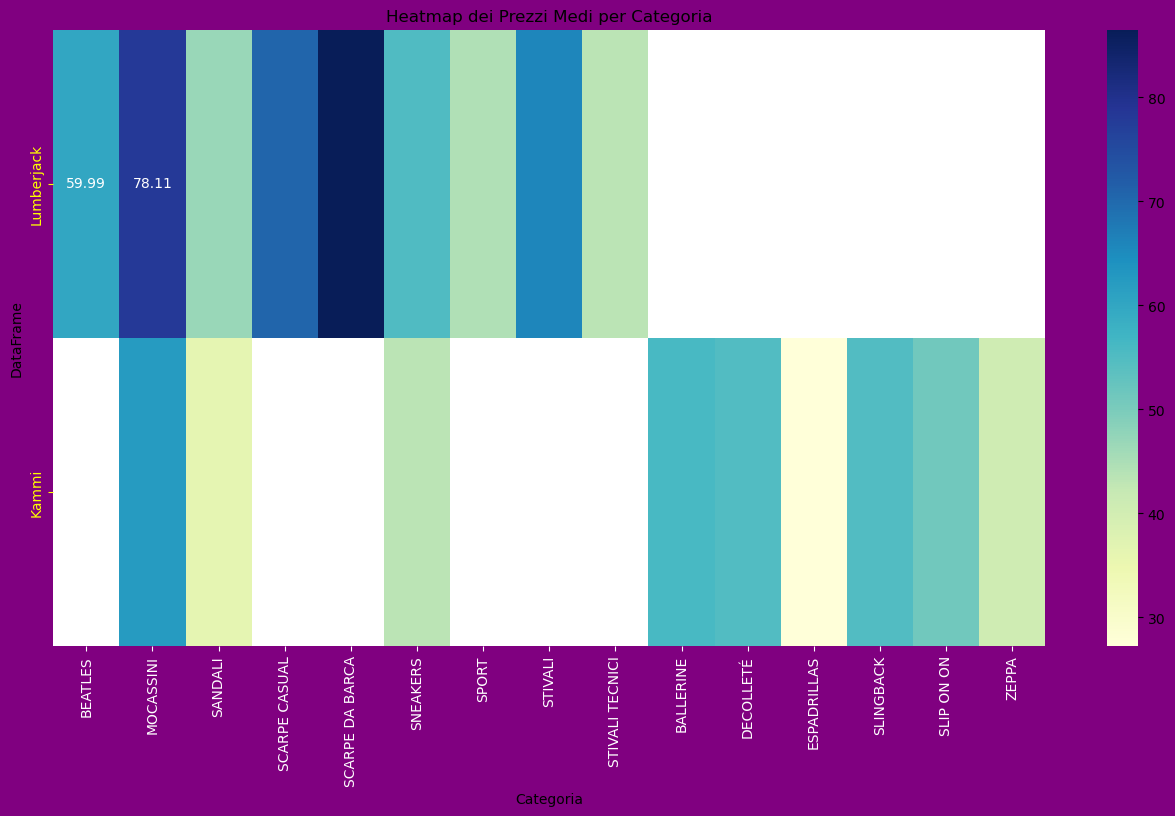

In [250]:
#Procedo a fare i grafici concentrandomi sui prezzi medi ( unico grafico utilizzato, volendo il massimo e minimo sostituisco max e min al posto di mean)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

# Calcolo del prezzo medio per ogni categoria in ciascun DataFrame
mean_prices_df_copy = df_copy.groupby('Categoria')['Prezzo'].mean().reset_index()
mean_prices_df_copy2 = df_copy2.groupby('Categoria')['Prezzo'].mean().reset_index()

# Rinomino la colonna Prezzo per distinguere i due DataFrame
mean_prices_df_copy.columns = ['Categoria', 'Lumberjack']
mean_prices_df_copy2.columns = ['Categoria', 'Kammi']

# Unisco i due DataFrame sulle categorie
merged_df = pd.merge(mean_prices_df_copy, mean_prices_df_copy2, on='Categoria', how='outer')

# Creo della matrice per la Heatmap
heatmap_data = merged_df.set_index('Categoria').transpose()

# Creazione della Heatmap ( Grafico scelto per avere un confronto a schermo dei 2 dataset di semplice lettura)
plt.figure(figsize=(16, 8),facecolor="purple")

# Genero i limiti degli assi
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()


sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')
plt.gca().tick_params(axis='x', colors='white')  # colore degli assi x
plt.gca().tick_params(axis='y', colors='yellow')  # colore degli assi y
plt.title('Heatmap dei Prezzi Medi per Categoria')
plt.xlabel('Categoria')
plt.ylabel('DataFrame')
plt.show()

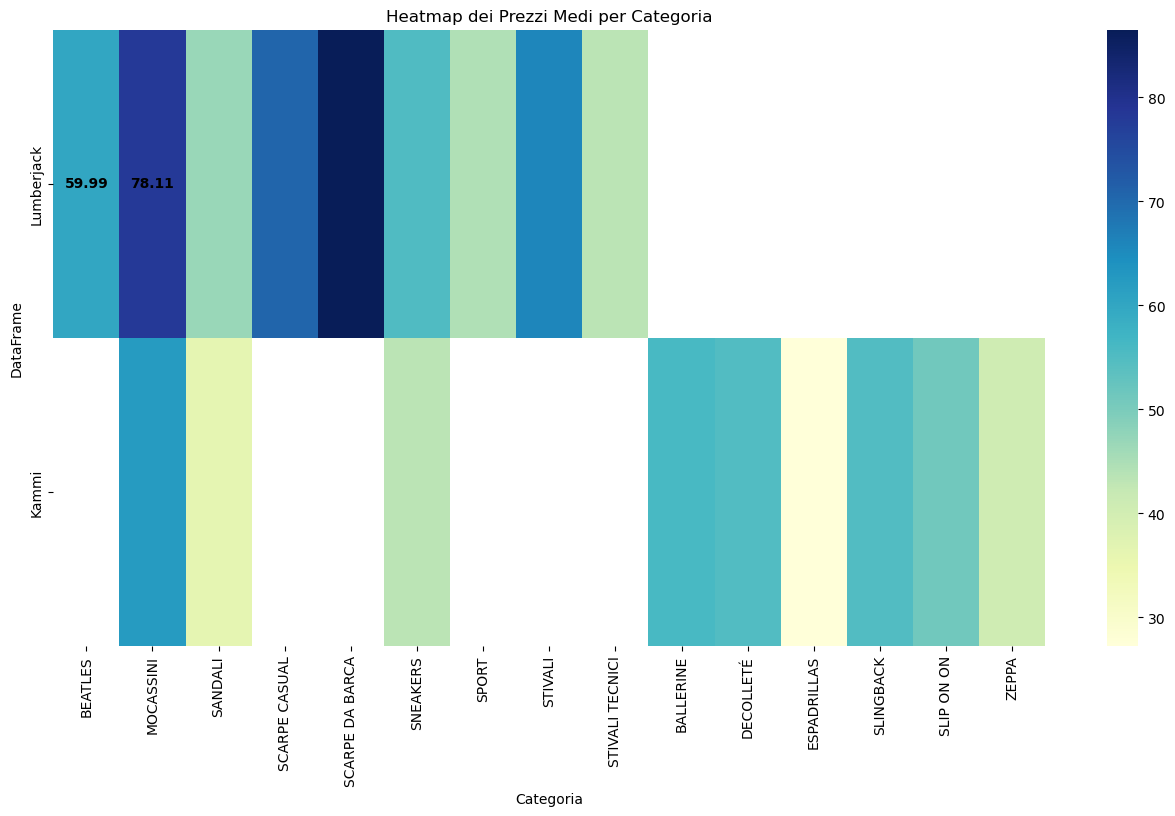

In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Calcolo del prezzo medio per ogni categoria in ciascun DataFrame
mean_prices_df_copy = df_copy.groupby('Categoria')['Prezzo'].mean().reset_index()
mean_prices_df_copy2 = df_copy2.groupby('Categoria')['Prezzo'].mean().reset_index()

# Rinomino la colonna Prezzo per distinguere i due DataFrame
mean_prices_df_copy.columns = ['Categoria', 'Lumberjack']
mean_prices_df_copy2.columns = ['Categoria', 'Kammi']

# Unisco i due DataFrame sulle categorie con un outer join
merged_df = pd.merge(mean_prices_df_copy, mean_prices_df_copy2, on='Categoria', how='outer')

# Riempie i valori mancanti con NaN (o un altro valore se preferisci)
merged_df = merged_df.fillna(value=np.nan)

# Limita i valori numerici a due cifre decimali
merged_df['Lumberjack'] = merged_df['Lumberjack'].round(2)
merged_df['Kammi'] = merged_df['Kammi'].round(2)

# Creo della matrice per la Heatmap
heatmap_data = merged_df.set_index('Categoria').transpose()

# Creazione della Heatmap
plt.figure(figsize=(16, 8))

# Genera la heatmap con annotazioni e specifica le proprietà delle annotazioni
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar=True, fmt='.2f', annot_kws={"size": 10, "weight": "bold", "color": "black"})

plt.gca().tick_params(axis='x', colors='black')  # colore degli assi x
plt.gca().tick_params(axis='y', colors='black')  # colore degli assi y
plt.title('Heatmap dei Prezzi Medi per Categoria')
plt.xlabel('Categoria')
plt.ylabel('DataFrame')
plt.show()
